In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
from typing import Callable
import matplotlib as mpl
import numpy as np
import pandas as pd

# Apply the default theme
# sns.set_theme()
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 150

import sys

sys.path.append("..")

from src.data.promptloader import (
    PromptLoader,
    GigawordDataLoader,
    DailymailDataLoader,
    TweetQADataLoader,
    RottenTomatoesDataLoader,
    MMLUAbstractAlgebraDataLoader,
    GSM8KDataLoader,
    MMLUHumanAgingDataLoader,
)
from src.eval.eval_metric import evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams.update({
    # 'font.size': 8,
    # 'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

load_dotenv()

/workspace/git/llm-task-switch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
def get_results(folder: Path, all_reference_data: list[str], use_cached: bool = True):
    

    pred_file = Path(folder) / "predictions.json"

    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [3]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b", "gpt3.5", "gpt4"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True,
    iterative=True,
    seed = False
):
    results = []
    for model_folder in model_folder_names:
        eval_folder: Path = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for num_examples_folder in in_ctxt_folder.iterdir():
                f = num_examples_folder / "iterative" if iterative else num_examples_folder
                results_folders = []
                if seed:
                    for seed_folder in f.iterdir():
                        if not seed_folder.is_dir():
                            continue
                        if not "seed" in seed_folder.name:
                            continue
                        results_folders.append(seed_folder)
                # else:
                #     results_folders.append(f)
                # Also append the results from the non-seed folder (this is seed=1)
                results_folders.append(f)
                    
                for res_folder in results_folders:
                    try:
                        res.append(get_results(res_folder, all_ref_data, use_cached=use_cached))
                    except Exception as e:
                        print(f"Error processing {str(res_folder)}")
                        print(e)


            res = [r for r in res if r]
            results.extend(res)
    return results

In [4]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 7)
# print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
    "mmluaa": pastel_colors[4],
    "gsm8k": pastel_colors[5],
    "mmlu-age": pastel_colors[6],
}

dataset_label = {
    "tweetqa": "TweetQA",
    "gigaword": "Gigaword",
    "dailymail": "Dailymail",
    "rotten_tomatoes": "Rotten Tomatoes",
    "mmluaa": "MMLU Abstract Algebra",
    "gsm8k": "GSM8K",
    "mmlu-age": "MMLU Human Aging",
}

model_label = {
    "mistral-7b": "Mistral-7B",
    "llama-7b": "Llama-7B",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "mixtral": "Mixtral",
}

In [5]:
def plot_df_metrics_per_model(
  results_df: pd.DataFrame,
  metrics: list[str],
  x="num_examples",
  save_path: Path = None,
  title: str = None,
  adjust_func: Callable = lambda _: _,
  eval_set: str = "",
  legend_anchor: tuple[float, float] = (0.95, 1.5),
  legend_axs = (-1, 0),
  xlim: tuple = (0, 6),
  legend_rows: int = 2,
  save_png: bool = False,
  fig_xlabel= r'Conversation History Length $L$',
  error_bar_pi=100,
):
    """Plot metrics for each dataset and model
    
    axis per model
    line per dataset

    x-axis: number of examples
    y-axis: metric
    """
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    num_models = len(results_df["model"].unique())
    fig, axs = plt.subplots(
        figsize=(12.5, 2 * num_metrics), 
        nrows=num_metrics, 
        ncols=num_models, 
        sharex=True, 
        sharey='row', 
        squeeze=False,
    )

    for y_idx, (metric, axs_y) in enumerate(zip(metrics, axs)):
        for x_idx, (ax, (model, df)) in enumerate(zip(axs_y, results_df.groupby("model"))):
            for (inctxt, df_inctxt) in df.groupby("incontext_set"):
                df_inctxt = df_inctxt.sort_values("num_examples")

                g = sns.lineplot(
                    data=df_inctxt,
                    x=x,
                    y=metric,
                    ax=ax,
                    label=dataset_label[inctxt],
                    color=dataset_color[inctxt],
                    marker="X",
                    errorbar=("pi", error_bar_pi),
                )

                # Remove ylabel
                # ax.set_ylabel("")
                # if x_idx == 0:
                #     ax.set_ylabel(metric)

                ax.yaxis.set_tick_params(labelbottom=True)
                
                if y_idx == 0:
                    ax.set_title(model_label[model])
                ax.legend_.remove()

            ax.set_xlim(xlim)
            # ax.set_xlabel(r"History Length $L$")
            ax.set_xlabel("")

    # Add legend
    # plot_dataset_models_legend(axs[-1, 0])
    legend = axs[legend_axs].legend(
        loc="upper left", 
        bbox_to_anchor=legend_anchor, 
        ncol=len(results_df["incontext_set"].unique()) // legend_rows,
        # nrow=2,
        fancybox=True,
        shadow=True,
    )
    legend.set_title("Conversation History Task")
    # Colour eval set label
    if eval_set:
        for text in legend.get_texts():
            if text.get_text() == dataset_label[eval_set]:
                # make bold
                # text.set_weight("bold")
                # text.set_color("red")
                text.set_text(rf"\textbf{{{text.get_text()}}}")
    if title:
        fig.suptitle(title)
    # plt.tight_layout()
    adjust_func(axs)
    fig.text(0.5, -0.1, fig_xlabel, ha='center')
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        if save_png:
            plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()
            

In [6]:
def df_metric_pct_change(df: pd.DataFrame, metric: str):
    """Calculate the percentage change of a metric"""
    df[f"{metric}_pct_change"] = 0.
    for row in df[["model", "incontext_set", metric]].itertuples():
        try:
            baseline_metric = df[(df["model"] == row.model) & (df["incontext_set"] == row.incontext_set) & (df["num_examples"] == 0)][metric].values[0]
            df.loc[row.Index, f"{metric}_pct_change"] = (row[-1] - baseline_metric) / baseline_metric * 100
        except Exception as e:
            print(e)
            print(row)
    return df

In [7]:
def expectation_metrics(df: pd.DataFrame):
    """Calculte the sensitivity metrics of the responses
    
    These metrics are calculated as the expected value of the ratio of likelihoods.
    Further details can be found in the paper in Appendix E.
    We also mention the formulae in `likelihoods.py`
    """

    metrics_dict = {
        "base_likelihood": "exp_base",   # zero-shot sensitivity
        "final_likelihood": "exp_final", # confidence sensitivity
        "ref_likelihood": "exp_ref",     # loss sensitivity
    }
    assert all(m in df.columns for m in metrics_dict.keys()), f"Missing metrics: {metrics_dict.keys()}"

    for exp_metric in metrics_dict.values():
        df[exp_metric] = np.nan

    for row in df[
        [
            *metrics_dict.keys(),
            "model",
            "incontext_set",
        ]
    ].itertuples():
        for idx, metric in enumerate(metrics_dict.keys()):
            # Find the baseline metric
            baseline_metric = df[
                (df["model"] == row.model) & (df["num_examples"] == 0)
            ][metric].values
            # filter out None
            baseline_metric = [bm for bm in baseline_metric if not bm is None]
            if len(baseline_metric) > 0:
                base_log_likelihoods = np.array(baseline_metric[0])
            else:
                continue

            # Extract the row metric
            log_likelihoods = row[idx + 1]
            if log_likelihoods is None:
                continue

            log_likelihoods = np.array(log_likelihoods)

            # Assert that the lengths are the same
            assert len(base_log_likelihoods) == len(
                log_likelihoods
            ), f"Lengths of baseline and likelihood are different for {metric}"

            # Calculate the Expected [baseline_metric / metric]
            exp_likelihood = np.exp(base_log_likelihoods - log_likelihoods)
            exp_likelihood = np.log(exp_likelihood)
            exp_likelihood = np.mean(exp_likelihood)
            df.loc[row.Index, metrics_dict[metric]] = exp_likelihood
    return df

In [8]:
def results_markdown_table(
    df: pd.DataFrame,
    metrics: list[str],
    task: str,
    num_examples: int = 6,
):
    """
    Create a markdown table of results
    Format: | dataset | model | metric1 | std |
    NOTE: first row block is for the task
    """
    # sort datasets
    datasets = sorted(list(df["incontext_set"].unique()))
    datasets.remove(task)
    datasets = [task] + datasets # put task first

    table = ""
    
    # header
    table += "| CH-Task | Model | " + " | ".join([f"Mean {m} | {m} Std" for m in metrics]) + " |\n"
    table += "| --- | --- " + " | --- | ---" * len(metrics) + " |\n"

    for dataset in datasets:
        for model in sorted(df["model"].unique()):
            table += f"| {dataset_label[dataset]} | {model_label[model]} "
            for metric in metrics:
                df_model = df[(df["model"] == model) & (df["incontext_set"] == dataset)]
                df_model = df_model[df_model["num_examples"] == num_examples]
                mean = df_model[metric].mean()
                std = df_model[metric].std()
                table += f"| {mean:.2f} | {std:.2f} "
            table += "|\n"

    return table

In [9]:
def markdown_task_distance_rank(df: pd.DataFrame, metric: str, ranks):
  """
  Format: | CH Task | Rank | metric for Model | metric for Model | 
  """
  
  table = ""

  models = sorted(list(df["model"].unique()))
  
  # header
  table += "| CH Task | Rank | " + " | ".join([f"{model_label[mod]}" for mod in models]) + " |\n"
  table += "| --- | --- " + " | --- | ---" * len(models) + " |\n"

  for dataset, rank in ranks.items():
    table += f"| {dataset_label[dataset]} | {rank} "
    for model in models:
      df_model = df[(df["model"] == model) & (df["incontext_set"] == dataset)]
      mean = df_model[metric].mean()
      # std = df_model[metric].std()
      table += f"| {mean:.2f} "
      # table += f"| {mean:.2f} | {std:.2f} "
    table += "|\n"
    
  return table

In [10]:
def markdown_task_distance(df: pd.DataFrame, metric: str, rank_col: str):
  """
  Format: | CH Task | CH Task Length (\# Tokens) | metric for Model | metric for Model | 
  """
  table = ""

  models = sorted(list(df["model"].unique()))

  # Take the mean of the rank col and sort to get CH task order
  ranks = df.groupby("incontext_set")[rank_col].mean().sort_values()

  # header
  table += "| CH Task | CH Task Length (# Tokens) | " + " | ".join([f"{model_label[mod]}" for mod in models]) + " |\n"
  table += "| --- | --- " + " | --- | ---" * len(models) + " |\n"

  for dataset, token_length in ranks.items():
    table += f"| {dataset_label[dataset]} | {token_length:.0f} "
    for model in models:
      df_model = df[(df["model"] == model) & (df["incontext_set"] == dataset)]
      mean = df_model[metric].mean()
      # std = df_model[metric].std()
      table += f"| {mean:.2f} "
      # table += f"| {mean:.2f} | {std:.2f} "
    table += "|\n"

  return table
  

In [11]:
def results_latex_table(
    df: pd.DataFrame,
    columns: list[str],
    task: str,
    num_examples: int = 5,
):
    """Print a dataframe as a latex table

    Args:
      df: dataframe
      columns: list of columns to include
      task: name of the task (this is printed as the first set of rows)

    Format:
      dataset | model | metric1 | metric2 | ...
    """

    empty_char = r"$*$"
    # empty_char = r"{\tiny\boxedsymbols{✗}}"

    # Sort datasets
    datasets = sorted(list(df["incontext_set"].unique()))
    datasets.remove(task)
    datasets = [task] + datasets

    # Print header
    print("CH-Task & Model & {" + "} & {".join(columns) + r"} \\")
    print(r"\midrule")

    for dataset in datasets:
        print(f"{dataset_label[dataset]} ")
        df_ds = df[df["incontext_set"] == dataset]
        for model, df_model in df_ds.groupby("model"):
            # print model
            print(f"& {model_label[model]} & ", end="")
            # filter by number of examples
            df_model = df_model[df_model["num_examples"] == num_examples]
            # extract relevant columns
            try:
                values = df_model[columns].mean().values
                # print values
                # make italics if it's the task
                italics = "" if dataset != task else r"\emph"
                print(
                    " & ".join(
                        [empty_char if np.isnan(v) else f"{italics}{{{v:.2f}}}" for v in values]
                    )
                    + r" \\"
                )
            except IndexError:
                print(" & ".join([empty_char] * len(columns)) + r" \\")

        if dataset != datasets[-1]:
            print(r"\midrule")
        if dataset == task:
            print(r"\midrule")

### Evaluate on RT

In [30]:
rt = RottenTomatoesDataLoader()
rt_reference_data = rt.load_test_reference()
rt_results = get_results_for_evalset(
    "rotten_tomatoes",
    rt_reference_data,
    use_cached=True,
    iterative=True,
    seed=True,
)

rt_results_df = pd.DataFrame.from_records(rt_results)

# remove dailymail
rt_results_df = rt_results_df[rt_results_df["incontext_set"] != "dailymail"]

print(len(rt_results_df))
rt_results_df.head()

Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_10/iterative
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_6/iterative
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_8/iterative
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_gigaword/num_examples_3/iterative
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_rotten_tomatoes/num_examples_3/iterative
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_tweetqa/num_examples_3/iterative
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_10/iterative
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_6/iterative
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_8/iterative
Sk

,matches,failed,total,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,seed,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length
3,924,1,1066,mistral-7b,gigaword,0,None,None,None,100.0,0.0,99.798311,4.493433,104.291745
4,924,1,1066,mistral-7b,gigaword,0,None,None,None,1000.0,0.0,99.798311,4.493433,104.291745
5,924,1,1066,mistral-7b,gigaword,0,None,None,None,10000.0,0.0,99.798311,4.493433,104.291745
6,924,1,1066,mistral-7b,gigaword,0,"[-4.045590400695801, -4.0538763999938965, -4.0...","[-4.045590400695801, -4.0538763999938965, -4.0...","[-4.220350742340088, -4.32817268371582, -4.091...",NaN,NaN,NaN,NaN,NaN
7,909,0,1066,mistral-7b,gigaword,10,None,None,None,NaN,NaN,NaN,NaN,NaN


In [25]:
len(rt_results_df)

72

In [31]:
df = rt_results_df
df["acc"] = df["matches"] / df["total"]
df = df_metric_pct_change(df, "acc")

# df.groupby(["model", "incontext_set", "num_examples"]).mean()

In [12]:
## Confusion matrix output

df[df["num_examples"] == 6]

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change
3,957,11,1066,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.592871,99.798311,11.157598,764.548780,0.897749,3.571429
4,954,13,1066,1000,mistral-7b,rotten_tomatoes,6,None,None,None,652.702627,99.798311,11.119137,763.620075,0.894934,3.246753
5,949,14,1066,10000,mistral-7b,rotten_tomatoes,6,None,None,None,651.350844,99.798311,11.193246,762.342402,0.890244,2.705628
12,936,0,1066,100,mistral-7b,mmluaa,6,None,None,None,862.561914,99.798311,10.977486,973.337711,0.878049,1.298701
13,935,0,1066,1000,mistral-7b,mmluaa,6,None,None,None,863.215760,99.798311,10.984991,973.999062,0.877111,1.190476
14,938,0,1066,10000,mistral-7b,mmluaa,6,None,None,None,864.334897,99.798311,10.969981,975.103189,0.879925,1.515152
21,911,0,1066,100,mistral-7b,tweetqa,6,None,None,None,553.764540,99.798311,2.000000,655.562852,0.854597,-1.406926
22,914,0,1066,1000,mistral-7b,tweetqa,6,None,None,None,553.280488,99.798311,2.000000,655.078799,0.857411,-1.082251
23,913,0,1066,10000,mistral-7b,tweetqa,6,None,None,None,553.151032,99.798311,2.000938,654.950281,0.856473,-1.190476
30,914,0,1066,100,mistral-7b,gigaword,6,None,None,None,443.148218,99.798311,2.000000,544.946529,0.857411,-1.082251


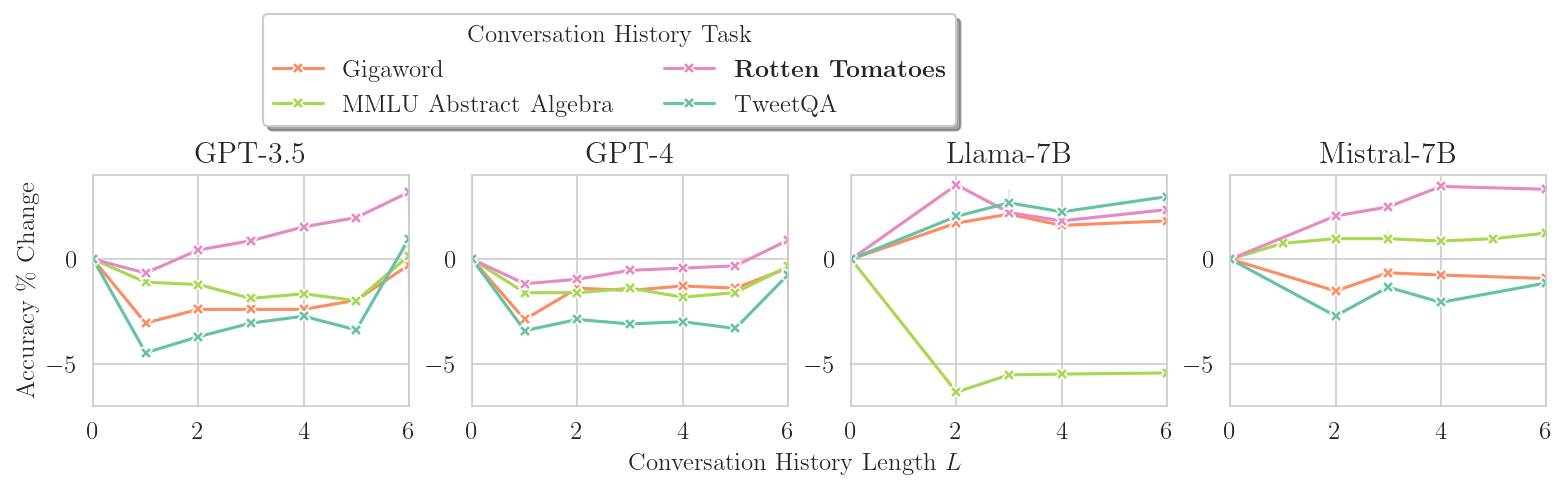

In [32]:
label = r"Accuracy \% Change"
df = rt_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/seeds_accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="rotten_tomatoes",
  legend_anchor=(-0.7, 1.75),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
)

In [33]:
print(results_markdown_table(df, [label], "rotten_tomatoes"))

| CH-Task | Model | Mean Accuracy \% Change | Accuracy \% Change Std |
| --- | ---  | --- | --- |
| Rotten Tomatoes | GPT-3.5 | 3.19 | 1.41 |
| Rotten Tomatoes | GPT-4 | 0.90 | 1.14 |
| Rotten Tomatoes | Llama-7B | 2.36 | 0.55 |
| Rotten Tomatoes | Mistral-7B | 3.33 | 0.47 |
| Gigaword | GPT-3.5 | -0.27 | 1.63 |
| Gigaword | GPT-4 | -0.43 | 2.39 |
| Gigaword | Llama-7B | 1.82 | 0.18 |
| Gigaword | Mistral-7B | -0.92 | 0.55 |
| MMLU Abstract Algebra | GPT-3.5 | 0.16 | 1.25 |
| MMLU Abstract Algebra | GPT-4 | -0.35 | 0.69 |
| MMLU Abstract Algebra | Llama-7B | -5.42 | 0.22 |
| MMLU Abstract Algebra | Mistral-7B | 1.24 | 0.23 |
| TweetQA | GPT-3.5 | 0.98 | 3.35 |
| TweetQA | GPT-4 | -0.74 | 1.49 |
| TweetQA | Llama-7B | 2.98 | 0.53 |
| TweetQA | Mistral-7B | -1.14 | 0.23 |



In [13]:
print(results_markdown_table(df, [label], "rotten_tomatoes"))

| CH-Task | Model | Mean Accuracy \% Change | Accuracy \% Change Std |
| --- | ---  | --- | --- |
| Rotten Tomatoes | Llama-7B | 2.54 | 0.51 |
| Rotten Tomatoes | Mistral-7B | 3.17 | 0.44 |
| Gigaword | Llama-7B | 1.82 | 0.21 |
| Gigaword | Mistral-7B | -0.79 | 0.60 |
| MMLU Abstract Algebra | Llama-7B | -5.33 | 0.16 |
| MMLU Abstract Algebra | Mistral-7B | 1.33 | 0.17 |
| TweetQA | Llama-7B | 2.72 | 0.12 |
| TweetQA | Mistral-7B | -1.23 | 0.17 |



### Distance Metric: Format (MCQ, Essay)

RT, MMLU, TweetQA, Gigaword

Results df: num_examples, inctxt, model, (seed), 

In [44]:
df = rt_results_df

# remove num_examples == 0
df = df[df["num_examples"] > 0]

ranks = {
  "rotten_tomatoes": 1,
  "tweetqa": 2,
  "gigaword": 3,
  "mmluaa": 4,
}
df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: ranks[inctxt])
df.head()

/tmp/ipykernel_86237/2586078217.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: ranks[inctxt])


,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change,inctxt_rank
0,948,15,1066,100,mistral-7b,rotten_tomatoes,3,None,None,None,327.220450,99.798311,11.084428,438.103189,0.889306,2.597403,1
1,947,15,1066,1000,mistral-7b,rotten_tomatoes,3,None,None,None,325.981238,99.798311,11.209193,436.988743,0.888368,2.489177,1
2,946,14,1066,10000,mistral-7b,rotten_tomatoes,3,None,None,None,327.063790,99.798311,11.121951,437.984053,0.887430,2.380952,1
3,957,11,1066,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.592871,99.798311,11.157598,764.548780,0.897749,3.571429,1
4,954,13,1066,1000,mistral-7b,rotten_tomatoes,6,None,None,None,652.702627,99.798311,11.119137,763.620075,0.894934,3.246753,1


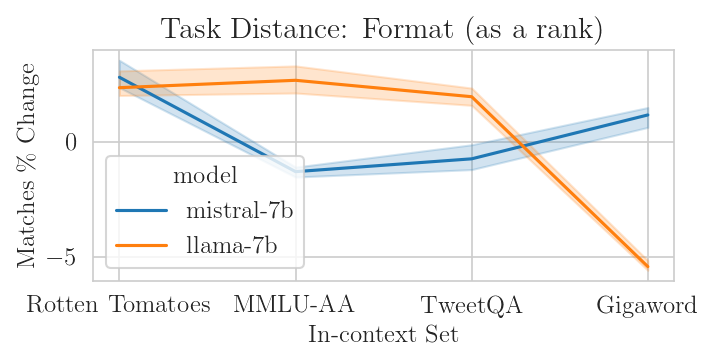

In [45]:
# plot rank against matches_pct_change
fig, ax = plt.subplots(figsize=(5, 2))

sns.lineplot(
    data=df,
    x="inctxt_rank",
    y="acc_pct_change",
    hue="model",
    ax=ax,
    errorbar=("pi", 100),
)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["Rotten Tomatoes", "MMLU-AA", "TweetQA", "Gigaword"])
# rotate xlabels
# plt.xticks(rotation=10)
ax.set_xlabel("In-context Set")
ax.set_ylabel(r"Matches \% Change")
ax.set_title("Task Distance: Format (as a rank)")
plt.show()

In [46]:
metric = "acc_pct_change"
print("Metric: ", metric)
print(markdown_task_distance_rank(df, metric, ranks))

Metric:  acc_pct_change
| CH Task | Rank | Llama-7B | Mistral-7B |
| --- | ---  | --- | --- | --- | --- |
| Rotten Tomatoes | 1 | 2.38 | 2.83 |
| TweetQA | 2 | 2.70 | -1.28 |
| Gigaword | 3 | 1.98 | -0.72 |
| MMLU Abstract Algebra | 4 | -5.42 | 1.19 |



,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change
6,924,1,1066,100,mistral-7b,rotten_tomatoes,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
7,924,1,1066,1000,mistral-7b,rotten_tomatoes,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
8,924,1,1066,10000,mistral-7b,rotten_tomatoes,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
15,924,1,1066,100,mistral-7b,mmluaa,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
16,924,1,1066,1000,mistral-7b,mmluaa,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
17,924,1,1066,10000,mistral-7b,mmluaa,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
24,924,1,1066,100,mistral-7b,tweetqa,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
25,924,1,1066,1000,mistral-7b,tweetqa,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
26,924,1,1066,10000,mistral-7b,tweetqa,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0
33,924,1,1066,100,mistral-7b,gigaword,0,None,None,None,0.0,99.798311,4.493433,104.291745,0.866792,0.0


### Distance Metric: Length of Incontext Question (by number of tokens)

Options for length of question:
- CH Length

Results df: num_examples, inctxt, model, (seed), 

2


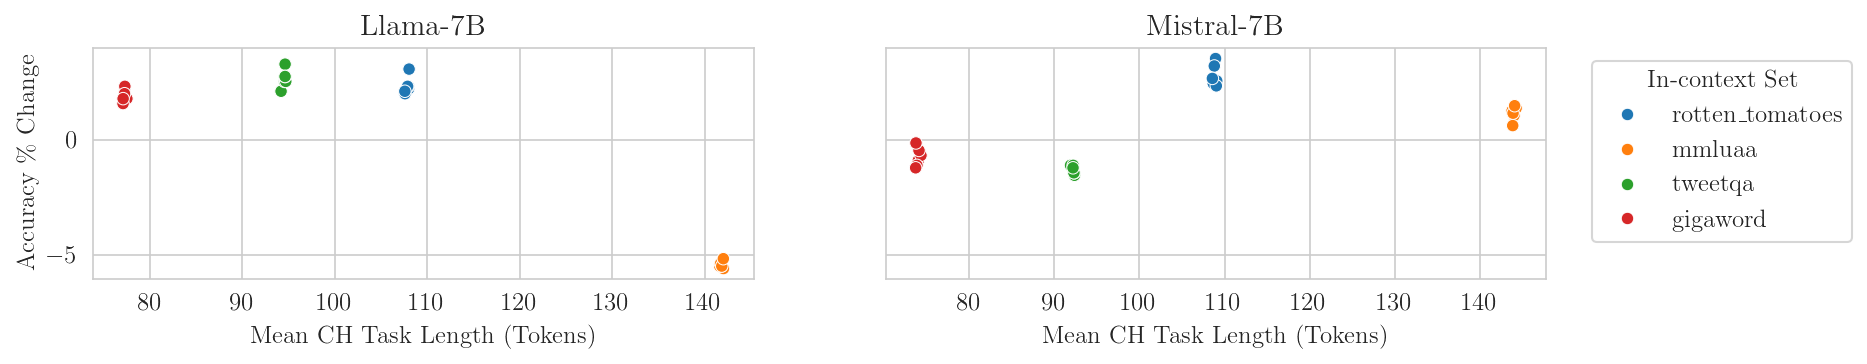

In [17]:
df = rt_results_df.copy()

# remove num_examples == 0
df = df[df["num_examples"] > 0]
# keep models: llama-7b, mistral-7b
df = df[df["model"].isin(["llama-7b", "mistral-7b"])]

rank_col = "mean_ch_len_1ex"
df[rank_col] = df["mean_conversation_history_length"] / df["num_examples"]

label = r"Accuracy \% Change"
df = df.rename(columns={"acc_pct_change": label})

num_models = len(df["model"].unique())
print(num_models)

fig, axs = plt.subplots(figsize=(12.5, 2), nrows=1, ncols=num_models, sharey=True, squeeze=False)

for idx, (model, df_model) in enumerate(df.groupby("model")):
    sns.scatterplot(data=df_model, x=rank_col, y=label, hue="incontext_set", ax=axs[0, idx])
    axs[0, idx].set_title(model_label[model])
    axs[0, idx].set_xlabel(r"Mean CH Task Length (Tokens)")
    axs[0, idx].legend_.remove()

# sns.scatterplot(data=df, x="mean_ch_len_1ex", y=label, hue="incontext_set", style="model")
plt.legend(title="In-context Set", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [18]:
# output table of results
d = df.groupby(["model", "incontext_set"]).mean()
d = d[[label, rank_col]]
d = d.reset_index()
print(markdown_task_distance(d, label, rank_col))

| CH Task | CH Task Length (# Tokens) | Llama-7B | Mistral-7B |
| --- | ---  | --- | --- | --- | --- |
| Gigaword | 76 | 1.98 | -0.72 |
| TweetQA | 93 | 2.70 | -1.28 |
| Rotten Tomatoes | 108 | 2.38 | 2.83 |
| MMLU Abstract Algebra | 143 | -5.42 | 1.19 |



### MMLU AA

In [12]:
aa = MMLUAbstractAlgebraDataLoader()
aa_ref_data = aa.load_test_reference()
aa_results = get_results_for_evalset(
    "mmluaa",
    aa_ref_data,
    use_cached=True,
    # use_cached=False,
    iterative=True,
    seed=True,
)
aa_results_df = pd.DataFrame(aa_results)

print(len(aa_results_df))
aa_results_df.head()

Skipping ../experiments/llama-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_0/iterative/seed_200
Skipping ../experiments/llama-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_1/iterative/seed_200
449


,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length
0,23,0,100,100.0,mistral-7b,gigaword,0,None,None,None,0.00,136.44,11.62,148.06
1,23,0,100,1000.0,mistral-7b,gigaword,0,None,None,None,0.00,136.44,11.62,148.06
2,23,0,100,10000.0,mistral-7b,gigaword,0,None,None,None,0.00,136.44,11.62,148.06
3,21,0,99,NaN,mistral-7b,gigaword,0,"[-1.1537379026412964, -1.2377865314483643, -1....","[-1.1537379026412964, -1.2377865314483643, -1....","[-3.360292911529541, -3.3725922107696533, -3.2...",NaN,NaN,NaN,NaN
4,22,0,100,100.0,mistral-7b,gigaword,1,None,None,None,72.47,136.44,15.71,224.62


In [13]:
aa_results_df["acc"] = aa_results_df["matches"] / aa_results_df["total"]
aa_results_df = df_metric_pct_change(aa_results_df, "acc")
aa_results_df = expectation_metrics(aa_results_df)

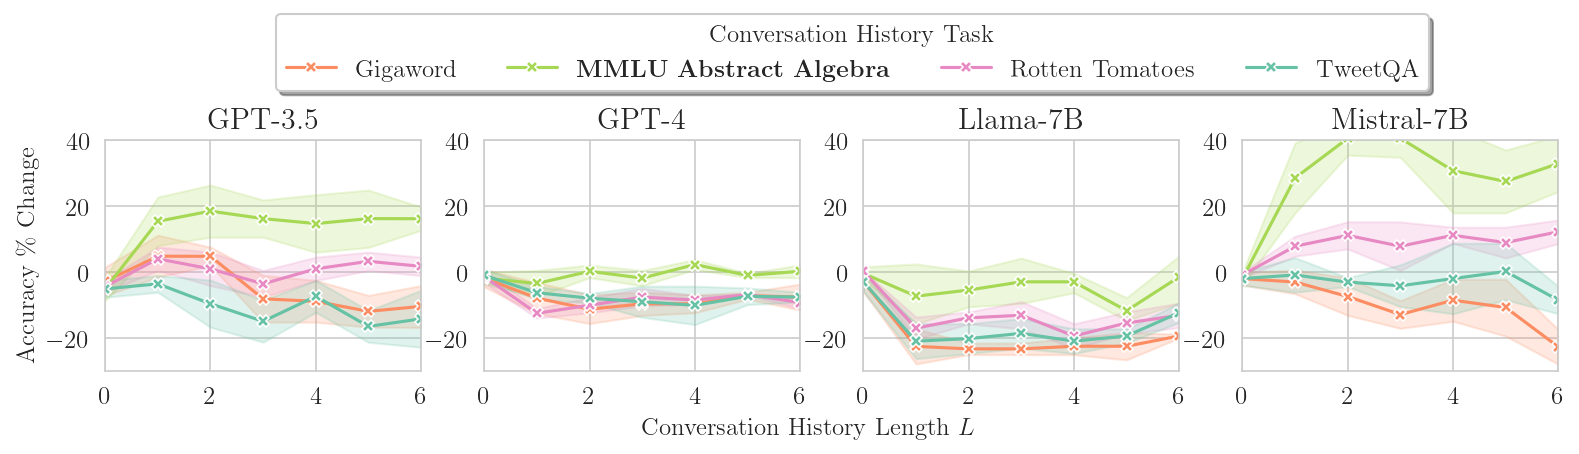

In [16]:
label = r"Accuracy \% Change"
df = aa_results_df.rename(columns={"acc_pct_change": label})
# df = df[(df["model"] != "gpt3.5")]
# df = df[(df["model"] != "gpt4")]
# df = df[(df["model"] == "llama-7b")]
plot_df_metrics_per_model(
  df, 
  [label], 
  save_path=Path("mmluaa/seeds_accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
  legend_anchor=(0.5, 1.6),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-30, 40),
  legend_rows=1,
  # legend_axs=(-1, 1),
  # save_png=True,
  error_bar_pi=67,
)

In [17]:
print(results_markdown_table(aa_results_df, ["acc_pct_change"], "mmluaa"))

| CH-Task | Model | Mean acc_pct_change | acc_pct_change Std |
| --- | ---  | --- | --- |
| MMLU Abstract Algebra | GPT-3.5 | 16.19 | 5.51 |
| MMLU Abstract Algebra | GPT-4 | 0.26 | 3.12 |
| MMLU Abstract Algebra | Llama-7B | -1.41 | 14.93 |
| MMLU Abstract Algebra | Mistral-7B | 32.91 | 12.08 |
| Gigaword | GPT-3.5 | -10.37 | 11.34 |
| Gigaword | GPT-4 | -7.55 | 4.54 |
| Gigaword | Llama-7B | -19.33 | 1.17 |
| Gigaword | Mistral-7B | -22.64 | 7.32 |
| Rotten Tomatoes | GPT-3.5 | 1.77 | 3.81 |
| Rotten Tomatoes | GPT-4 | -9.21 | 3.08 |
| Rotten Tomatoes | Llama-7B | -13.07 | 4.56 |
| Rotten Tomatoes | Mistral-7B | 12.24 | 5.58 |
| TweetQA | GPT-3.5 | -14.14 | 11.87 |
| TweetQA | GPT-4 | -7.55 | 2.65 |
| TweetQA | Llama-7B | -12.28 | 4.44 |
| TweetQA | Mistral-7B | -8.48 | 5.95 |



In [62]:
# Main Results Table
df = aa_results_df

# remove in_context dailymail
# df = df[~((df["incontext_set"] == "dailymail"))]
columns={
    r"acc_pct_change": r"\% Change",
    r"exp_base": r"$\tau(\cdot)$",
}

df = df.rename(columns=columns)

results_latex_table(
    df,
    columns.values(),
    task="mmluaa",
    num_examples=6,
)

CH-Task & Model & {\% Change} & {$\tau(\cdot)$} \\
\midrule
MMLU Abstract Algebra 
& GPT-3.5 & \emph{16.19} & $*$ \\
& GPT-4 & \emph{0.26} & $*$ \\
& Llama-7B & \emph{-1.41} & \emph{0.19} \\
& Mistral-7B & \emph{32.91} & \emph{0.10} \\
\midrule
\midrule
Gigaword 
& GPT-3.5 & {-10.37} & $*$ \\
& GPT-4 & {-7.55} & $*$ \\
& Llama-7B & {-19.33} & {0.03} \\
& Mistral-7B & {-22.64} & {0.28} \\
\midrule
Rotten Tomatoes 
& GPT-3.5 & {1.77} & $*$ \\
& GPT-4 & {-9.21} & $*$ \\
& Llama-7B & {-13.07} & {0.07} \\
& Mistral-7B & {12.24} & {0.04} \\
\midrule
TweetQA 
& GPT-3.5 & {-14.14} & $*$ \\
& GPT-4 & {-7.55} & $*$ \\
& Llama-7B & {-12.28} & {0.04} \\
& Mistral-7B & {-8.48} & {0.25} \\


### Length of Conversation vs Accuracy

In [24]:
df

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,Accuracy \% Change
0,26,0,100,100,mistral-7b,rotten_tomatoes,3,None,None,None,328.45,136.44,11.11,476.00,0.26,13.043478
1,27,0,100,1000,mistral-7b,rotten_tomatoes,3,None,None,None,328.31,136.44,11.11,475.86,0.27,17.391304
2,23,0,100,10000,mistral-7b,rotten_tomatoes,3,None,None,None,324.05,136.44,11.08,471.57,0.23,0.000000
3,26,0,100,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.10,136.44,11.11,800.65,0.26,13.043478
4,27,0,100,1000,mistral-7b,rotten_tomatoes,6,None,None,None,657.74,136.44,11.11,805.29,0.27,17.391304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,26,3,100,1000,llama-7b,gigaword,6,None,None,None,457.90,134.65,143.02,735.57,0.26,-18.750000
70,26,6,100,10000,llama-7b,gigaword,6,None,None,None,462.27,134.65,140.20,737.12,0.26,-18.750000
71,32,1,100,100,llama-7b,gigaword,0,None,None,None,0.00,134.65,177.87,312.52,0.32,0.000000
72,32,1,100,1000,llama-7b,gigaword,0,None,None,None,0.00,134.65,177.87,312.52,0.32,0.000000


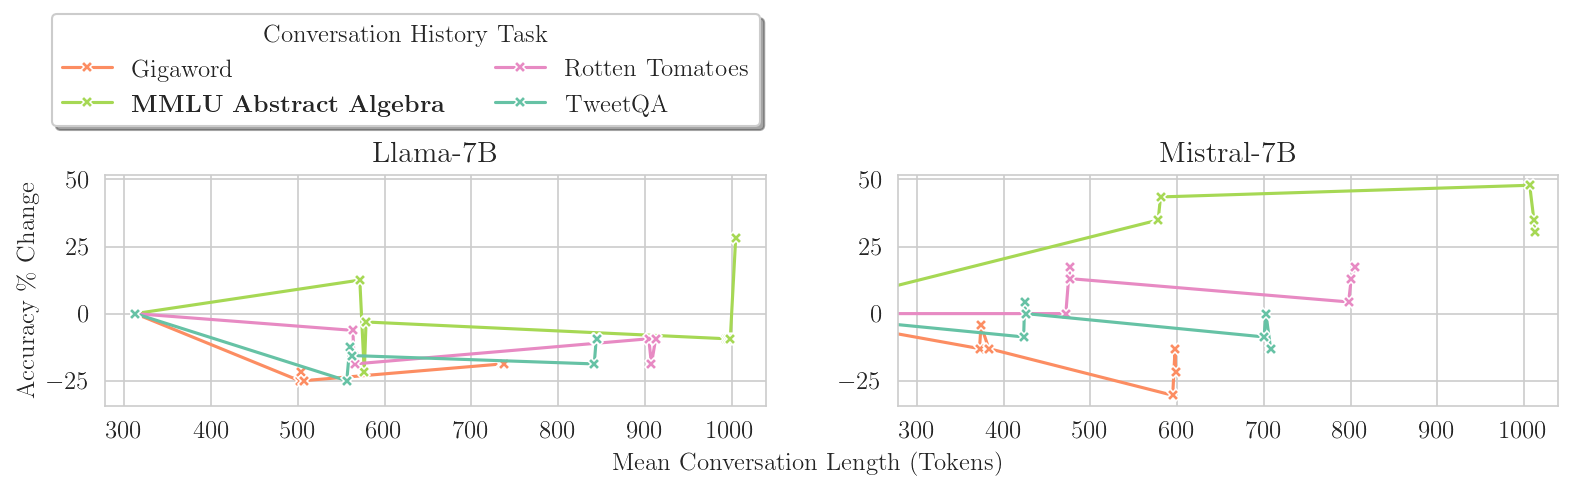

In [25]:
label = r"Accuracy \% Change"
df = aa_results_df.rename(columns={"acc_pct_change": label})
# keep models: llama-7b, mistral-7b
df = df[df["model"].isin(["llama-7b", "mistral-7b"])]
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  x="mean_conversation_length",
  eval_set="mmluaa",
  legend_anchor=(-1.3, 1.75),
  xlim=None,
  # adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
  fig_xlabel=r"Mean Conversation Length (Tokens)",
)

In [26]:
d = df.groupby(["model", "incontext_set", "num_examples"]).mean()
d = d[[label, "mean_conversation_length"]]
d = d.reset_index()
# d

model = "mistral-7b"
d = d[d["model"] == model]

task = "mmluaa"
# sort datasets
datasets = sorted(list(d["incontext_set"].unique()))
datasets.remove(task)
datasets = [task] + datasets # put task first

table = ""

# header
table += "| CH-Task | CH Length $L$ | " + " | ".join([f"Mean {m}" for m in [label, "Conversation Length (# Tokens)"]]) + " |\n"
table += "| --- | --- " + " | --- | ---" * 2 + " |\n"

for dataset in datasets:
    for num_examples in sorted(d["num_examples"].unique()):
        table += f"| {dataset_label[dataset]} | {num_examples} "
        df_model = d[(d["model"] == model) & (d["incontext_set"] == dataset) & (d["num_examples"] == num_examples)]
        for metric in [label, "mean_conversation_length"]:
            mean = df_model[metric].mean()
            # std = df_model[metric].std()
            table += f"| {mean:.2f} "
        table += "|\n"


print(table)

| CH-Task | CH Length $L$ | Mean Accuracy \% Change | Mean Conversation Length (# Tokens) |
| --- | ---  | --- | --- | --- | --- |
| MMLU Abstract Algebra | 0 | 0.00 | 148.06 |
| MMLU Abstract Algebra | 3 | 37.68 | 578.52 |
| MMLU Abstract Algebra | 6 | 37.68 | 1010.16 |
| Gigaword | 0 | 0.00 | 148.06 |
| Gigaword | 3 | -10.14 | 376.23 |
| Gigaword | 6 | -21.74 | 596.83 |
| Rotten Tomatoes | 0 | 0.00 | 148.06 |
| Rotten Tomatoes | 3 | 10.14 | 474.48 |
| Rotten Tomatoes | 6 | 11.59 | 801.17 |
| TweetQA | 0 | 0.00 | 148.06 |
| TweetQA | 3 | -1.45 | 424.21 |
| TweetQA | 6 | -7.25 | 703.32 |



### Distance Metric: Format (MCQ, Essay)

MMLU, RT, TweetQA, Gigaword

Results df: num_examples, inctxt, model, (seed), 

In [47]:
df = aa_results_df

df["acc"] = df["matches"] / df["total"]
df = df_metric_pct_change(df, "acc")

# remove num_examples == 0
df = df[df["num_examples"] > 0]

mmlu_ranks = {
  "mmluaa": 1,
  "gigaword": 2,
  "tweetqa": 3,
  "rotten_tomatoes": 4,
}
df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: mmlu_ranks[inctxt])
df.head()

/tmp/ipykernel_86237/43432699.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: mmlu_ranks[inctxt])


,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change,inctxt_rank
0,26,0,100,100,mistral-7b,rotten_tomatoes,3,None,None,None,328.45,136.44,11.11,476.00,0.26,13.043478,4
1,27,0,100,1000,mistral-7b,rotten_tomatoes,3,None,None,None,328.31,136.44,11.11,475.86,0.27,17.391304,4
2,23,0,100,10000,mistral-7b,rotten_tomatoes,3,None,None,None,324.05,136.44,11.08,471.57,0.23,0.000000,4
3,26,0,100,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.10,136.44,11.11,800.65,0.26,13.043478,4
4,27,0,100,1000,mistral-7b,rotten_tomatoes,6,None,None,None,657.74,136.44,11.11,805.29,0.27,17.391304,4


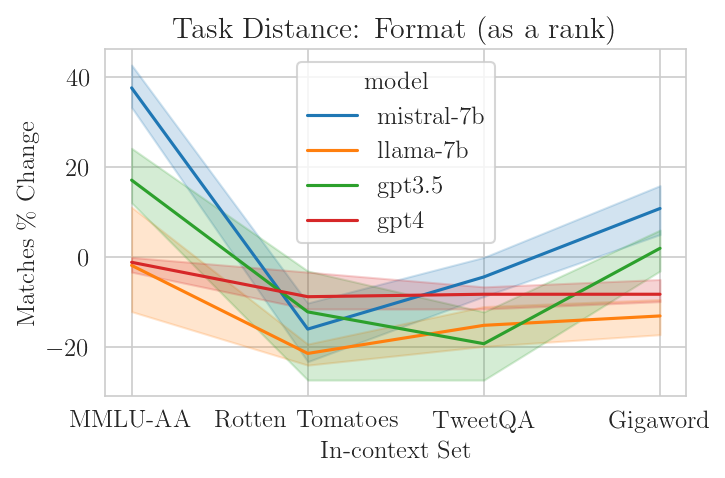

In [48]:
# plot rank against matches_pct_change
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(data=df, x="inctxt_rank", y="acc_pct_change", hue="model", ax=ax)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["MMLU-AA", "Rotten Tomatoes", "TweetQA", "Gigaword"])
# rotate xlabels
# plt.xticks(rotation=10)
ax.set_xlabel("In-context Set")
ax.set_ylabel(r"Matches \% Change")
ax.set_title("Task Distance: Format (as a rank)")
plt.show()

In [49]:
metric = "acc_pct_change"
print("Metric: ", metric)
print(markdown_task_distance_rank(df, metric, mmlu_ranks))

Metric:  acc_pct_change
| CH Task | Rank | GPT-3.5 | GPT-4 | Llama-7B | Mistral-7B |
| --- | ---  | --- | --- | --- | --- | --- | --- | --- | --- |
| MMLU Abstract Algebra | 1 | 17.17 | -1.09 | -1.79 | 37.68 |
| Gigaword | 2 | -12.12 | -8.74 | -21.35 | -15.94 |
| TweetQA | 3 | -19.19 | -8.20 | -15.10 | -4.35 |
| Rotten Tomatoes | 4 | 2.02 | -8.20 | -13.02 | 10.87 |



### Distance Metric: Length of Incontext Question (by number of tokens)

Options for length of question:
- CH Length

Results df: num_examples, inctxt, model, (seed), 

In [30]:
df.head()

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,mean_conversation_history_length,mean_target_task_length,mean_pred_tokens_length,mean_conversation_length,acc,acc_pct_change,inctxt_rank
0,26,0,100,100,mistral-7b,rotten_tomatoes,3,None,None,None,328.45,136.44,11.11,476.00,0.26,13.043478,2
1,27,0,100,1000,mistral-7b,rotten_tomatoes,3,None,None,None,328.31,136.44,11.11,475.86,0.27,17.391304,2
2,23,0,100,10000,mistral-7b,rotten_tomatoes,3,None,None,None,324.05,136.44,11.08,471.57,0.23,0.000000,2
3,26,0,100,100,mistral-7b,rotten_tomatoes,6,None,None,None,653.10,136.44,11.11,800.65,0.26,13.043478,2
4,27,0,100,1000,mistral-7b,rotten_tomatoes,6,None,None,None,657.74,136.44,11.11,805.29,0.27,17.391304,2


2


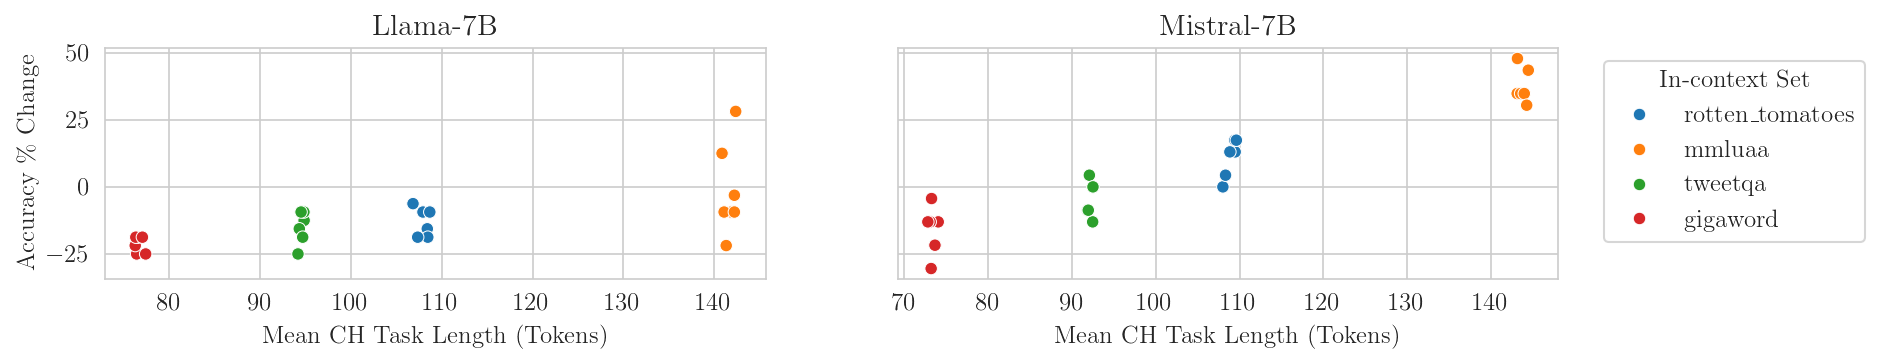

In [31]:
df = aa_results_df.copy()

# remove num_examples == 0
df = df[df["num_examples"] > 0]
# keep models: llama-7b, mistral-7b
df = df[df["model"].isin(["llama-7b", "mistral-7b"])]

rank_col = "mean_ch_len_1ex"
df[rank_col] = df["mean_conversation_history_length"] / df["num_examples"]

label = r"Accuracy \% Change"
df = df.rename(columns={"acc_pct_change": label})

num_models = len(df["model"].unique())
print(num_models)

fig, axs = plt.subplots(figsize=(12.5, 2), nrows=1, ncols=num_models, sharey=True, squeeze=False)

for idx, (model, df_model) in enumerate(df.groupby("model")):
    sns.scatterplot(data=df_model, x=rank_col, y=label, hue="incontext_set", ax=axs[0, idx])
    axs[0, idx].set_title(model_label[model])
    axs[0, idx].set_xlabel(r"Mean CH Task Length (Tokens)")
    axs[0, idx].legend_.remove()

# sns.scatterplot(data=df, x="mean_ch_len_1ex", y=label, hue="incontext_set", style="model")
plt.legend(title="In-context Set", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [32]:
# output table of results
d = df.groupby(["model", "incontext_set"]).mean()
d = d[[label, rank_col]]
d = d.reset_index()
print(markdown_task_distance(d, label, rank_col))

| CH Task | CH Task Length (# Tokens) | Llama-7B | Mistral-7B |
| --- | ---  | --- | --- | --- | --- |
| Gigaword | 75 | -21.35 | -15.94 |
| TweetQA | 93 | -15.10 | -4.35 |
| Rotten Tomatoes | 108 | -13.02 | 10.87 |
| MMLU Abstract Algebra | 143 | -1.79 | 37.68 |

